In [23]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# 
import keras
from keras.models import Model
from keras.regularizers import l2
from keras.activations import relu
from keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, LeakyReLU, Dense, Input, Concatenate, Activation, LeakyReLU

## Utils

In [24]:
def show_img(image, title=""):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"{title}")
    plt.show()
    
def apply_kernel(image: np.array, kernel: np.array):
    # edges = cv2.filter2D(src=image, cv2.CV_64F, kernel=kernel)
    edges = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    img_edges = np.uint8(np.absolute(edges))  # make to unsigned 8 bit int
    return img_edges

## Load Data

In [25]:
datapath = "./data.csv"
df = pd.read_csv(datapath)
df.head()

,filepath,filename,target,class
0,./data/desert/desert(1017).jpg,desert(1017).jpg,3,desert
1,./data/green_area/Forest_610.jpg,Forest_610.jpg,2,green_area
2,./data/desert/desert(1087).jpg,desert(1087).jpg,3,desert
3,./data/cloudy/train_2904.jpg,train_2904.jpg,0,cloudy
4,./data/cloudy/train_6891.jpg,train_6891.jpg,0,cloudy


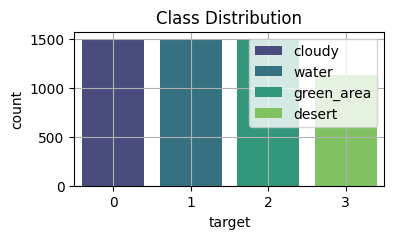

In [26]:
plt.figure(figsize=(4, 2))
sns.countplot(data=df, x="target", palette="viridis", hue='class')
plt.title("Class Distribution")
plt.grid(True)
plt.legend()
plt.show()

In [27]:
data = df['filepath'].values
images: list = list()

for ip in data:
    image = cv2.imread(ip, 0)
    dims = (200, 200)
    image = cv2.resize(image, dims, interpolation=cv2.INTER_AREA)
    images.append(image)

# show_img(images[0], "Resized Image")

## Feature Extraction

#### Gabor Filter

In [28]:
# ksize = 11
# sigma = 4.0
# theta = np.pi/4
# lambd = 10.0
# gamma = 0.5
# psi = 0

# gabor_kernel = cv2.getGaborKernel( (ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F )
# plt.imshow(gabor_kernel)
# plt.show()

In [29]:
# f_image = cv2.filter2D(src=image, ddepth=-1, kernel=gabor_kernel )
# f_image[: 6, : 6]

#### laplacian_kernel

In [30]:
filter_imgs : list = list()
laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
gs_dims = (5, 5) # Gaussian smoothing
# 
for image in images:
    # image = cv2.GaussianBlur(image, gs_dims, 0)
    lk_img = apply_kernel(image, laplacian_kernel)
    filter_imgs.append(lk_img)
filter_imgs = np.array(filter_imgs)

## Data Split And Normalisation

In [31]:
filter_imgs = filter_imgs / 255.0

In [32]:
x_train, x_test, y_train, y_test  = train_test_split(filter_imgs, df['target'], test_size=0.2, random_state=18 ) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4504, 200, 200), (1127, 200, 200), (4504,), (1127,))

## Train

#### LSTM

In [33]:
y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_train.shape

(4504, 4)

In [34]:
x_train.shape, y_train.shape

((4504, 200, 200), (4504, 4))

In [35]:
BATCH_SIZE = 16
DROPOUT_RATE = 0.4
LEARNING_RATE: int = 0.1e-3
INPUT_SHAPE = filter_imgs.shape[1:]
NUM_CLASSES = y_train.shape[-1]

#
input1 = Input(shape=(INPUT_SHAPE), name="first lstm input layer")
x1 = LSTM(64, return_sequences=True )(input1)
x1 = LSTM(32, return_sequences=True )(x1)
x1 = LSTM(16)(x1)
# 
x1 = BatchNormalization()(x1)
x1 = Dropout(DROPOUT_RATE)(x1)
x1 = Dense(64, activation='ReLU', activity_regularizer=l2(LEARNING_RATE))(x1)
# 
output = Dense(NUM_CLASSES, activation="softmax")(x1)
# 
model = Model(inputs=input1, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

# keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, show_layer_activations=True, show_trainable=True )
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first lstm input layer (In  [(None, 200, 200)]        0         
 putLayer)                                                       
                                                                 
 lstm_3 (LSTM)               (None, 200, 64)           67840     
                                                                 
 lstm_4 (LSTM)               (None, 200, 32)           12416     
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 16)                0   

In [36]:
y_eval = keras.utils.to_categorical(y_test, NUM_CLASSES)
x_test.shape, y_eval.shape

((1127, 200, 200), (1127, 4))

In [37]:
x_train.shape, y_train.shape

((4504, 200, 200), (4504, 4))

In [38]:
EPOCHS = 20
model_history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    epochs=EPOCHS, verbose=1
)

Epoch 1/20
282/282 [==============================] - 30s 99ms/step - loss: 0.6361 - accuracy: 0.7376 - val_loss: 0.4832 - val_accuracy: 0.8199
Epoch 2/20
282/282 [==============================] - 35s 123ms/step - loss: 0.3789 - accuracy: 0.8524 - val_loss: 0.5438 - val_accuracy: 0.7303
Epoch 3/20
282/282 [==============================] - 28s 98ms/step - loss: 0.3076 - accuracy: 0.9019 - val_loss: 0.7487 - val_accuracy: 0.6770
Epoch 4/20
282/282 [==============================] - 28s 99ms/step - loss: 0.3016 - accuracy: 0.8970 - val_loss: 0.3351 - val_accuracy: 0.8864
Epoch 5/20
282/282 [==============================] - 30s 107ms/step - loss: 0.2619 - accuracy: 0.9127 - val_loss: 0.2969 - val_accuracy: 0.8926
Epoch 6/20
282/282 [==============================] - 27s 97ms/step - loss: 0.2528 - accuracy: 0.9156 - val_loss: 0.3221 - val_accuracy: 0.9077
Epoch 7/20
282/282 [==============================] - 27s 97ms/step - loss: 0.2235 - accuracy: 0.9272 - val_loss: 0.4879 - val_accurac

#### Save Model To File

In [39]:
# model.save("./models/laplacian_model.keras")

## Evaluate

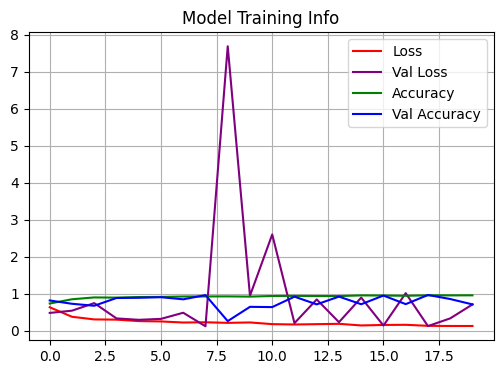

In [40]:
s = model_history.history

plt.figure(figsize=(6, 4))
plt.plot(s['loss'], label="Loss", color="red")
plt.plot(s['val_loss'], label="Val Loss", color="purple" )
plt.plot(s['accuracy'], label="Accuracy", color="green" )
plt.plot(s['val_accuracy'], label="Val Accuracy", color="blue" )
plt.title("Model Training Info")
plt.grid(True)
# y = [0, 1]
# plt.yticks(range(min(y), max(y)+1, 1))
plt.legend()
plt.show()

In [41]:
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_preds

36/36 [==============================] - 9s 150ms/step


array([3, 3, 2, ..., 2, 2, 0])

In [42]:
accuracy_score(y_test, y_preds)

0.7133984028393966

In [43]:
print(classification_report(y_test, y_preds, zero_division=1))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       290
           1       1.00      0.19      0.32       332
           2       0.52      0.98      0.68       294
           3       0.78      1.00      0.88       211

    accuracy                           0.71      1127
   macro avg       0.82      0.75      0.70      1127
weighted avg       0.83      0.71      0.67      1127



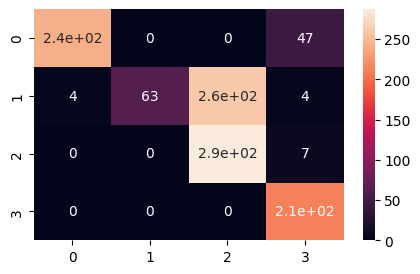

In [44]:
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True)
plt.show()